<a href="https://colab.research.google.com/github/LiviaAniely/Aplica-es-do-Processamento-de-Linguagem-Natural/blob/main/LiviaA_Agrupamento_de_poemas_com_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agrupamento de textos com K-Means

Neste notebook, foi usado o algoritmo K-Means, um algoritmo simples e popular de __*agrupamento não-supervisionado*__, para agrupar poemas em português em diferentes grupos.

O objetivo do K-means é simples: agrupar pontos de dados semelhantes e descobrir padrões subjacentes. Para atingir esse objetivo, o K-means procura um número fixo definido (k) de centróides em um conjunto de dados. Um centróide refere-se a um cluster, que é uma coleção de pontos de dados agregados devido a certas semelhanças entre si. As **médias/means** no K-means referem-se à média dos dados; isto é, encontrar o centróide. E o algoritmo é dito não supervisionado porque não temos conhecimento prévio sobre os grupos ou classes de nosso conjunto de dados, ou seja, encontraremos os grupos subjacentes em nosso conjunto de dados!

Abaixo podemos visualizar o algoritmo. Os centróides verdes correspondem aos pontos de dados mais próximos de cada um e formam clusters, então cada centróide se move para o centro de cada respectivo grupo e combina novamente os pontos de dados mais próximos entre si.

![alt text](https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Images/kmeans.gif?raw=true)

**Passos:**

__1.__ Explorar nossa coleção de poemas (corpus) <br>
__2.__ Aplicar engenharia de dados no conjunto de dados para obter o melhor desempenho do algoritmo K-means <br>
__3.__ Executar o algoritmo várias vezes, cada vez testando com um número diferente de clusters <br>
__4.__ Usar diferentes métricas para visualizar nossos resultados e encontrar o melhor número de clusters (*ou seja, por que um total de X clusters é melhor do que um total de Y clusters?*) <br>
__5.__ Análise de cluster

**Métricas utilizadas para determinar o melhor número de K Cluters:**
- [Método do cotovelo](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

## Importando bibliotecas

In [ ]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 4.2 MB/s eta 0:00:00


In [ ]:
# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cmm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

import urllib.request

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Carregando o corpus

Usaremos pandas para ler o arquivo csv contendo o hino nacional de cada país e seu código de país correspondente. Os hinos foram extraídos da wikipedia e muitos deles contém palavras que usam caracteres não UTF-8 (geralmente nomes de lugares e tal), então vamos ler o arquivo com a codificação _latin1_.

Em seguida, extrairemos a coluna __Anthem__ em uma lista de textos para nosso corpus.

In [ ]:
data = pd.read_csv('https://gist.githubusercontent.com/issilva5/b4a1c6dc5989ad83663ae02929f2894c/raw/17d27552de56f3b38c5c2823b26e8bd77318cbc0/poemas.csv', encoding='utf-8')
data.columns = map(str.lower, data.columns)

#data = data.sample(frac=0.1)
data

,author,content
0,Cecília Meireles,"Retrato\nEu não tinha este rosto de hoje,\nAss..."
1,Fernando Pessoa,"Para ser grande, sê inteiro: nada\nPara ser gr..."
2,Marina Colasanti,"Eu sei, mas não devia\nEu sei que a gente se a..."
3,Carlos Drummond de Andrade,Quadrilha\nJoão amava Teresa que amava Raimund...
4,Eugénio de Andrade,É urgente o amor\nÉ urgente o amor.\nÉ urgente...
...,...,...
8978,Susana Thénon,"Não é um Poema\nOs rostos são os mesmos,os cor..."
8979,Antidio Cabal,"Epitáfio de Ramón Suelo, vulgo O Calado\nQuand..."
8980,Sandro Penna,Como é forte o ruído da aurora\nComo é forte o...
8981,Sandro Penna,Alfio que um trem transporta para longe.\nAlfi...


In [ ]:
corpus = data['content'].tolist()

print(len(corpus))

8983


## Processando o corpus

### 1. Stop Words and Stemming
Faremos uma rotina de engenharia de dados com nosso dataset de hinos para posteriormente fazermos um bom modelo estatístico. Para isso, removeremos todas as palavras que não contribuam para o significado semântico do texto (palavras que não estão dentro do alfabeto inglês) e manteremos todas as palavras restantes no formato mais simples possível, para que possamos aplicar uma função que dê pesos a cada palavra sem gerar nenhum viés ou outliers. Para isso existem várias técnicas para limpar nosso corpus, entre elas vamos remover as palavras mais comuns ([stop words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)) e aplicar [stemming](https://www.researchgate.net/figure/Stemming-process-Algorithms-of-stemming-methods-are-divided-into-three-parts-mixed_fig2_324685008), uma técnica que reduz uma palavra a é raiz.

Os métodos que aplicam a remoção de stemming e stop words estão listados abaixo. Também definiremos um método que remove todas as palavras com menos de 2 letras ou mais de 21 letras para limpar ainda mais nosso corpus.

In [ ]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

### 2. A função principal de processamento

Uma seção atrás, na exploração de nosso conjunto de dados, notamos algumas palavras contendo caracteres estranhos que deveriam ser removidos. Ao usar o RegEx, nossa principal função de processamento removerá símbolos ASCII desconhecidos, caracteres especiais, números, e-mails, URLs, etc. Ele também usa as funções auxiliares definidas acima.

In [ ]:
def getAuthorList(data):
     authors = data['author'].to_list()
     authors = [author.lower().split(' ') for author in authors]
     authors = sum(authors, [])
     authors = list(set(authors))
     return authors

def processCorpus(corpus, language):
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    authors = getAuthorList(data)

    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase

        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, authors)

        listOfTokens = applyStemming(listOfTokens, param_stemmer)


        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [ ]:
language = 'portuguese'
corpus = processCorpus(corpus, language)
corpus[0][0:460]

'retrat rost hoj assim calm assim trist assim magr olhos ta vazi labi amarg ma forc ta par fri mort coraca mostr dei mudanc ta simpl ta cert ta facil espelh fic perd fac'

### Aplicando a vetorização com TF-IDF

Agora vamos aplicar a função [TF-IDF](https://jmotif.github.io/sax-vsm_site/morea/algorithm/TFIDF.html), abreviação de frequência do documento inverso da frequência do termo, que é uma estatística numérica que se destina para refletir a importância de uma palavra para um documento em um corpus, atribuindo a cada palavra em um documento uma pontuação que varia de 0 a 1.

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

8983 rows


,0,1,2,3,4,5,6,7,8,9,...,8973,8974,8975,8976,8977,8978,8979,8980,8981,8982
ta,0.526113,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.025946,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076035,0.0
assim,0.328233,0.12838,0.0,0.0,0.0,0.032667,0.0,0.513367,0.053958,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
mudanc,0.221804,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
magr,0.217612,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
facil,0.204071,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [ ]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,8973,8974,8975,8976,8977,8978,8979,8980,8981,8982
ta,0.526113,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.025946,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076035,0.0
assim,0.328233,0.12838,0.0,0.0,0.0,0.032667,0.0,0.513367,0.053958,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
mudanc,0.221804,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
magr,0.217612,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
facil,0.204071,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## Aplicando o K-Means

Função que executa o algoritmo K-Means *max_k* vezes e retorna um dicionário de cada k resultante.

In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 1
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )

    return kmeans_results

In [ ]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)


## Encontrando o melhor resultado

#### Método do cotovelo

Calcularemos o método do cotovelo usando a soma do quadrado das distâncias das ammostras a seus respectivos centros

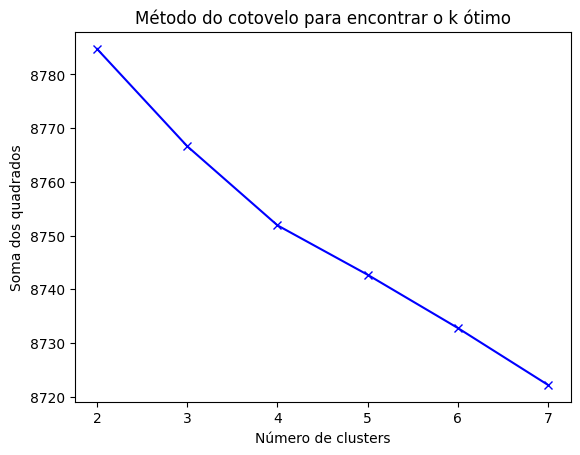

In [ ]:
sum_of_squared_distances = []
n = range(2, k)
for i in n:
    sum_of_squared_distances.append(kmeans_results[i].inertia_)

plt.plot(n, sum_of_squared_distances, 'bx-')
plt.xlabel("Número de clusters")
plt.ylabel("Soma dos quadrados")
plt.title('Método do cotovelo para encontrar o k ótimo')
plt.show()

#### Silhouette Score

O Silhouette Score é uma medida de quão semelhante um objeto é ao seu próprio cluster (coesão) em comparação com outros clusters (separação).

In [ ]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))

def plotSilhouette(df, n_clusters, splotn, plot_idx, kmeans_labels, silhouette_avg):
    ax1 = plt.subplot(splotn, splotn, plot_idx)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("K = %d, SS = %.4f" % (n_clusters, silhouette_avg)), fontsize=10, fontweight='bold')

    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples


def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    subplots_num = int(np.ceil(np.sqrt(k)))
    plot_idx = 0

    if plot:
        fig = plt.figure(figsize=(15,15))

    for n_clusters, kmeans in kmeans_dict.items():
        plot_idx += 1
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {n_clusters : silhouette_avg} )

        if(plot): plotSilhouette(df, n_clusters, subplots_num, plot_idx, kmeans_labels, silhouette_avg)

    if plot:
        plt.show()

    return avg_dict

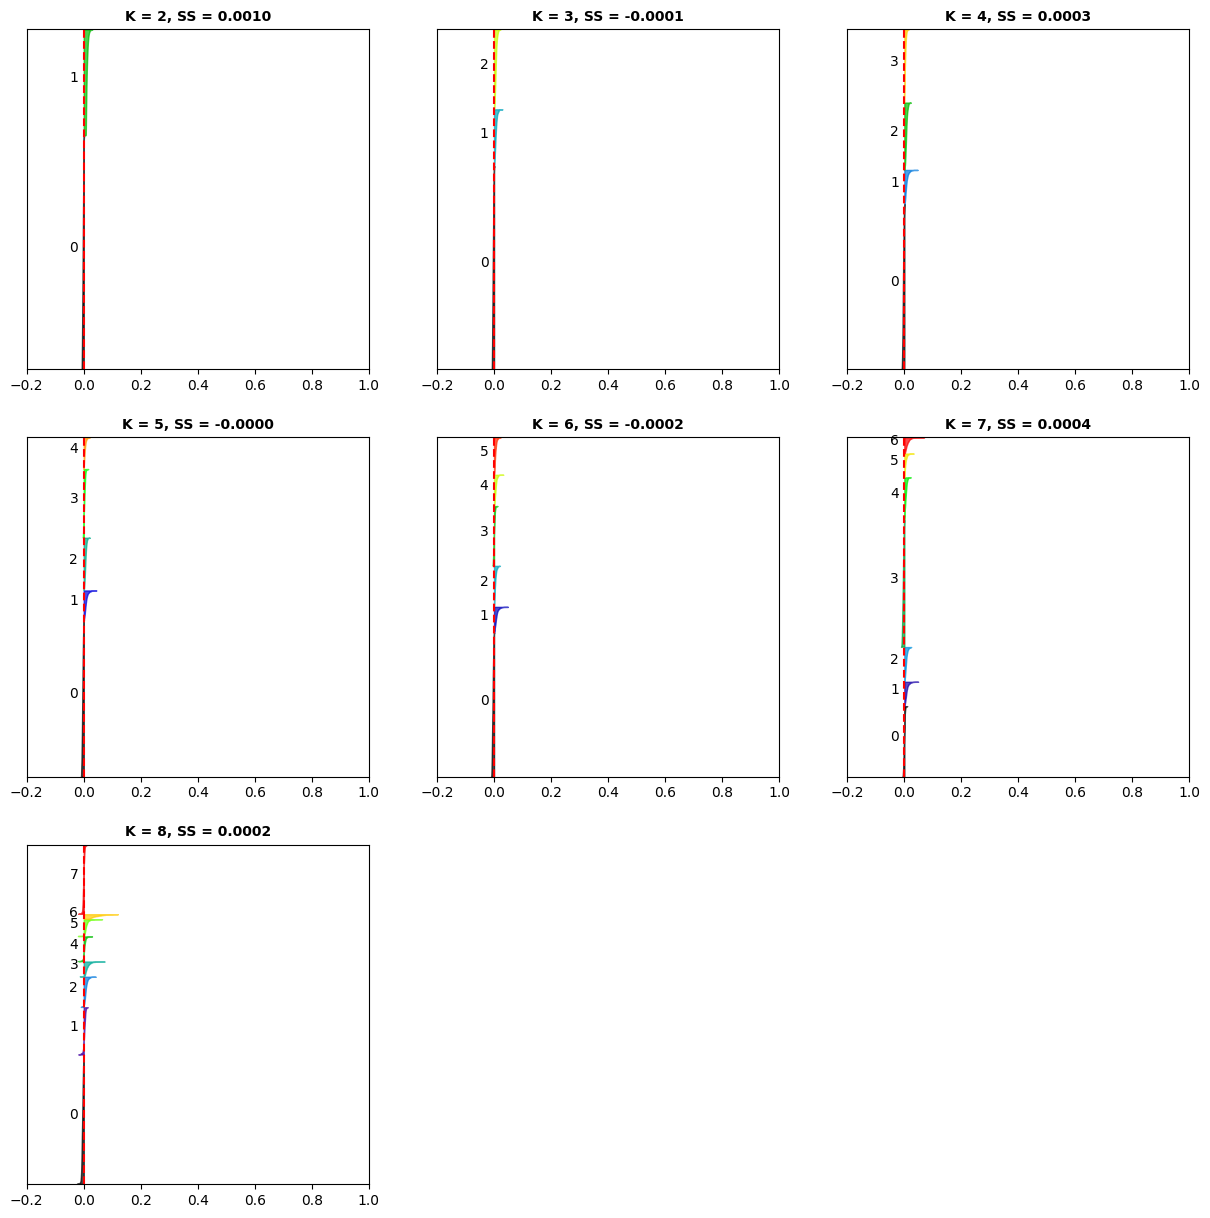

In [ ]:
# Plotting Silhouette Analysis
ss_dict = silhouette(kmeans_results, final_df, plot=True)

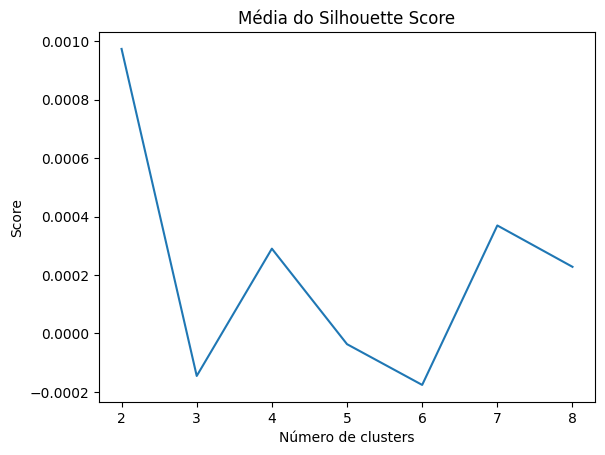

In [ ]:
df_silhouette = pd.DataFrame({'n_clusters':ss_dict.keys(),'silhouette_score':ss_dict.values()})
ax = sns.lineplot(data=df_silhouette, x="n_clusters", y="silhouette_score")
ax.set(xlabel="Número de clusters", ylabel="Score", title="Média do Silhouette Score")
plt.show()

## Análise nos clusters

Agora podemos escolher o melhor número de K e dar uma olhada mais profunda em cada cluster. Olhando para os gráficos acima, temos algumas pistas de que quando K = 4 é quando os clusters são melhor definidos.
Usando o método do cotovelo, vemos que em K = 4, há uma diminuição na inclinação da reta, além de que vemos que no método da silhueta, o K = 4 é o 3° maior score. Geralmente considerariamos o de maior score, porém em K = 2, o resultado do método do cotovelo não é favorável, assim, ponderando entre os 2, o K = 4 é o mais adequado à escolha.

#### Histograma das palavras

Então, primeiro usaremos um histograma simples para observar as palavras mais dominantes em cada grupo:

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Palavras mais comuns Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

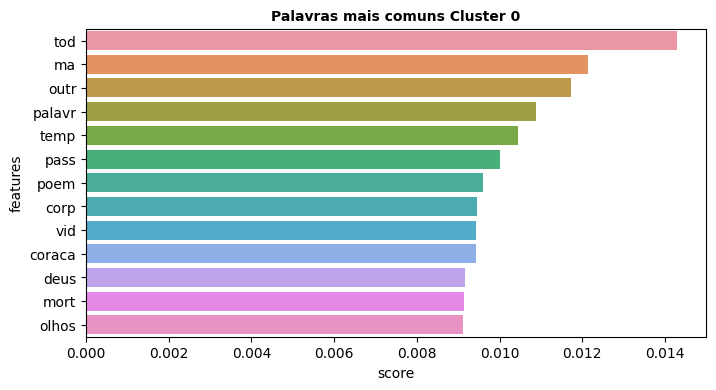

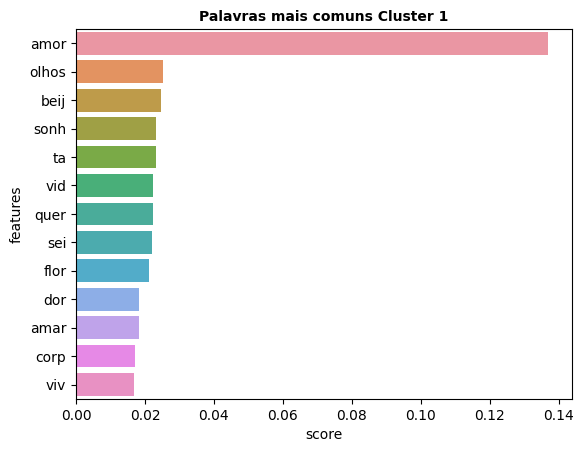

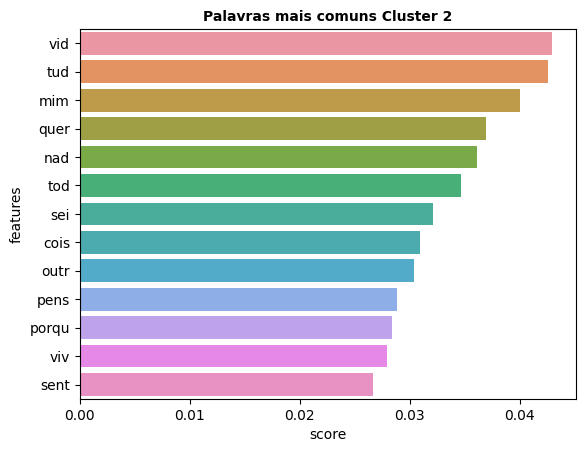

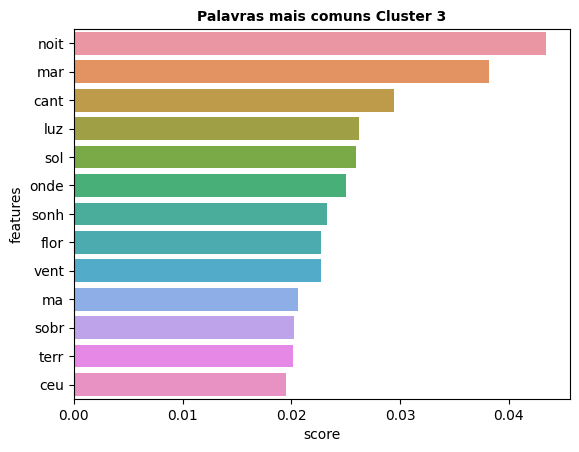

In [ ]:
best_result = 4
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

#### Wordcloud

Agora que podemos olhar os gráficos acima e ver as palavras mais bem pontuadas em cada cluster, também é interessante deixá-lo mais bonito fazendo um mapa de palavras de cada cluster!

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

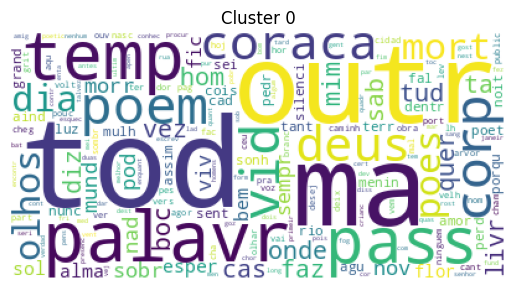

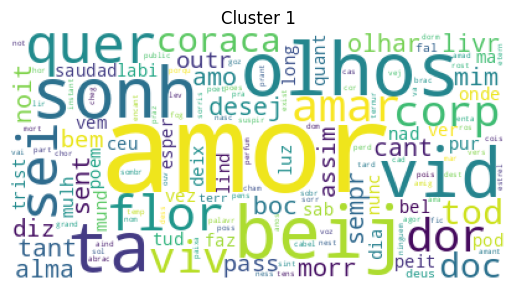

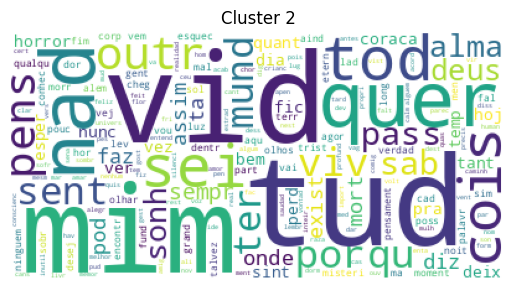

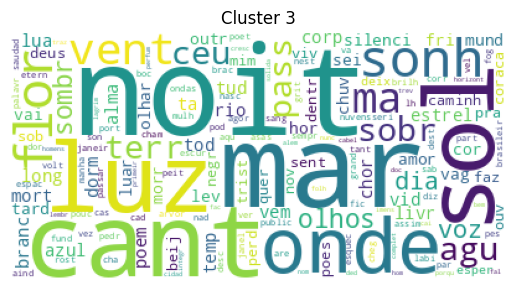

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

### Visualizando no map

In [ ]:
# Assigning the cluster labels to each country
labels = kmeans.labels_
data['label'] = labels
data.head()

,author,content,label
0,Cecília Meireles,"Retrato\nEu não tinha este rosto de hoje,\nAss...",2
1,Fernando Pessoa,"Para ser grande, sê inteiro: nada\nPara ser gr...",2
2,Marina Colasanti,"Eu sei, mas não devia\nEu sei que a gente se a...",2
3,Carlos Drummond de Andrade,Quadrilha\nJoão amava Teresa que amava Raimund...,0
4,Eugénio de Andrade,É urgente o amor\nÉ urgente o amor.\nÉ urgente...,1


## Interpretando seus resultados

### **1. Analisem a distribuição das palavras nos clusters: Quais são as palavras mais frequentes em cada cluster? É possível observar similaridade entre elas, ou seja, elas vêm de contextos similares?**

R. Analisando as palavras mais frequentes para cada um dos 4 clusters, temos que algumas das palavras mais frequentes são:

C0: "tod", "ma", "outr", "palavr", "temp", "pass". etc;

C1: "amor", "olhos", "beij", "sonh", "ta", "vid", etc;

C2: "vid", "tud", "mim", "quer", "nad", "tod", etc;

C3: "noit", "mar", "cant", "luz", "sol", "onde", etc.


É possível observar que várias das palavras podem ser consideradas de um contexto similar, apesar de algumas delas não possuirem significado sozinhas, as que têm sentido relembram uma temática que é a vida e os sentimentos, comum em poemas, palavras como "amor", "vid", "mort", "coraca", "ceu", "noit" são alguns exemplos.


### **2. Analisem a semântica de cada cluster e atribuam nomes que caracterizam cada cluster, quando isso fizer sentido.**

R.

C0: "Vida & Morte"

C1: "Amor"

C2: "Minha vida"

C3: "Natureza"


### **3. Analisem a distribuição dos poemas nos clusters: Os poemas se distribuem igualmente entre os clusters? Qual cluster tem mais poemas? Qual tem menos?**

Cada um dos 4 clusters têm a quantidade abaixo de poemas:

C0: 4371;

C1: 903;

C2: 1780;

C3: 1929.

Esses resultados podem observados ao ver-se o número de linhas que têm como label, cada um dos respectivos clusters, essas informações são extraídas nos 4 blocos de código abaixo:

In [ ]:
c0 = data[data['label'] == 0]
c0

,author,content,label
3,Carlos Drummond de Andrade,Quadrilha\nJoão amava Teresa que amava Raimund...,0
9,Manuel Bandeira,Poema tirado de uma notícia de jornal\nJoão Go...,0
10,Eugénio de Andrade,De palavra em palavra\nDe palavra em palavra\n...,0
13,Miguel Torga,Sei um ninho\nSei um ninho.\nE o ninho tem um ...,0
15,Thiago de Mello,Os Estatutos do Homem\n(Ato Institucional Perm...,0
...,...,...,...
8978,Susana Thénon,"Não é um Poema\nOs rostos são os mesmos,os cor...",0
8979,Antidio Cabal,"Epitáfio de Ramón Suelo, vulgo O Calado\nQuand...",0
8980,Sandro Penna,Como é forte o ruído da aurora\nComo é forte o...,0
8981,Sandro Penna,Alfio que um trem transporta para longe.\nAlfi...,0


In [ ]:
c1 = data[data['label'] == 1]
c1

,author,content,label
4,Eugénio de Andrade,É urgente o amor\nÉ urgente o amor.\nÉ urgente...,1
8,Gonçalves Dias,"Como eu te amo\nComo se ama o silêncio, a luz,...",1
11,Chacal,Primeiro eu quero falar de amor\nmeu amor se e...,1
16,Cecília Meireles,Tu tens um medo\nTu tens um medo:\nAcabar.\nNã...,1
20,Carlos Drummond de Andrade,Destruição\nOs amantes se amam cruelmente\ne c...,1
...,...,...,...
8848,Fernando Pessoa,"A folha insciente, antes que a própria morra\n...",1
8872,Sandro Penna,"Amor, amor\nAmor, amordileto dissabor.:Amore, ...",1
8905,Maria Ângela Alvim,Soneto ao amigo\nProcure ao largo de alma o le...,1
8919,Sandro Penna,"Juventude, amor, belas palavras,\nJuventude, a...",1


In [ ]:
c2 = data[data['label'] == 2]
c2

,author,content,label
0,Cecília Meireles,"Retrato\nEu não tinha este rosto de hoje,\nAss...",2
1,Fernando Pessoa,"Para ser grande, sê inteiro: nada\nPara ser gr...",2
2,Marina Colasanti,"Eu sei, mas não devia\nEu sei que a gente se a...",2
5,Vinicius de Moraes,"Procura-se um amigo\nNão precisa ser homem, ba...",2
7,Vinicius de Moraes,Eu sei e você sabe\nEu sei e você sabe\nJá que...,2
...,...,...,...
8882,Fernando Pessoa,A morte — esse pior que tem por força que acon...,2
8894,Raquel Nobre Guerra,O fim do mundo\nO fim do mundo começa sempre n...,2
8901,Raquel Nobre Guerra,É evidente que nos mentem\nÉ evidente que nos ...,2
8912,Fernando Pessoa,Os mistérios profundos e horrorosos;\nOs misté...,2


In [ ]:
c3 = data[data['label'] == 3]
c3

,author,content,label
6,Fernando Pessoa,"X. MAR PORTUGUÊS\nÓ mar salgado, quanto do teu...",3
12,Cecília Meireles,A arte de ser feliz\nHouve um tempo em que min...,3
21,Cecília Meireles,Pus o meu sonho num navio\nPus o meu sonho num...,3
24,Thiago de Mello,Solilóquio ao Pé do Berço\nCruzaste\na porta d...,3
31,José Gomes Ferreira,Devia morrer-se de outra maneira\nDevia morrer...,3
...,...,...,...
8831,Fernando Pessoa,"Tu, ao canto da janela,\nTu, ao canto da janel...",3
8833,Fernando Pessoa,"Toda a noite, toda a noite,\nToda a noite, tod...",3
8863,Fernando Pessoa,Monólogo à Noite\nTenha eu a dimensão e a form...,3
8864,Fernando Pessoa,"Ó curva do horizonte, quem te passa,\nÓ curva ...",3


### **4. Analisem a distribuição dos autores nos clusters: Qual o autor que aparece em mais clusters? Qual o autor que aparece em menos clusters? Quantos autores pertencem exclusivamente a um cluster?**

Considerando que temos 4 clusters, os autores que mais aparecem são os que estão em todos os clusters. Tivemos um total de 112 autores que apareceram nos 4 clusters, alguns deles são "Affonso Romano de Sant'Anna", "Al Berto", "Alfonsina Storni", "Alice Ruiz", etc.

Os autores que aparecem em menos clusters diferentes são aqueles que aparecem exclusivamente em um único cluster. Tivemos um total de 11 autores em 1 cluster, são alguns deles "Afrânio Peixoto", "Antidio Cabal", "António Lobo de Carvalho", etc.

Esses resultados podem ser analisados através da chamada da função abaixo, como observado no resultado da execução desse código.

In [ ]:
def authors_frequency_by_clusters(data):
  g = data.groupby('author')
  #g.describe()

  quant_labels_by_author = dict()

  #salvar quantidade de clusters que cada autor está presente
  for name, attributes in g:

    labels = set()

    for label in attributes.label:
      labels.add(label)

    quant_labels = len(labels)

    if(quant_labels in quant_labels_by_author):
      quant_labels_by_author[quant_labels].append(name)
    else:
      quant_labels_by_author[quant_labels] = list()
      quant_labels_by_author[quant_labels].append(name)

  return quant_labels_by_author



for i in range(1,5):
  print(f"Número de clusters diferentes: {i}")
  res = authors_frequency_by_clusters(data)[i]
  print(res)
  print(len(res))


Número de clusters diferentes: 1
['Afrânio Peixoto', 'Antidio Cabal', 'António Lobo de Carvalho', 'Juó Bananére', 'Lalla Romano', 'Leopoldo María Panero', 'Marcial', 'Micheliny Verunschk', 'Oscar Wilde', 'Sebastião Alba', 'Tite de Lemos']
11
Número de clusters diferentes: 2
['Affonso Ávila', 'Albano Dias Martins', 'Alberto de Oliveira', 'Alfred Edward Housman', 'Ana Cristina Cesar', 'Antonio Roberval Miketen', 'Antônio Barreto', 'Antônio Massa', 'Armando Freitas Filho', 'Arnaldo Antunes', 'Augusto Massi', 'Augusto de Campos', 'Barroso Gomes', 'Caio Valério Catulo', 'Casimiro de Abreu', 'Cláudio Manuel da Costa', 'Dora Ferreira da Silva', 'Dílson Catarino', 'E. M. de Melo e Castro', 'Emiliano Perneta', 'Emílio de Menezes', 'Fernando Correia Pina', 'Flávio Sátiro Fernandes', 'Fontoura Xavier', 'Fábio Afonso de Almeida', 'Gabriela Mistral', 'Geir Campos', 'Henriqueta Lisboa', 'Isabel Machado', 'Jorge Melícias', 'Jorge Viegas', 'Jorge de Lima', 'José Craveirinha', 'José Honório', 'José Mig